# Classification of SfM-derived point clouds using deep learning

- 🥠 Deep Learning
- ☁️ SfM-derived Point Cloud
- 🛰️ Remote Sensing

<p align="center">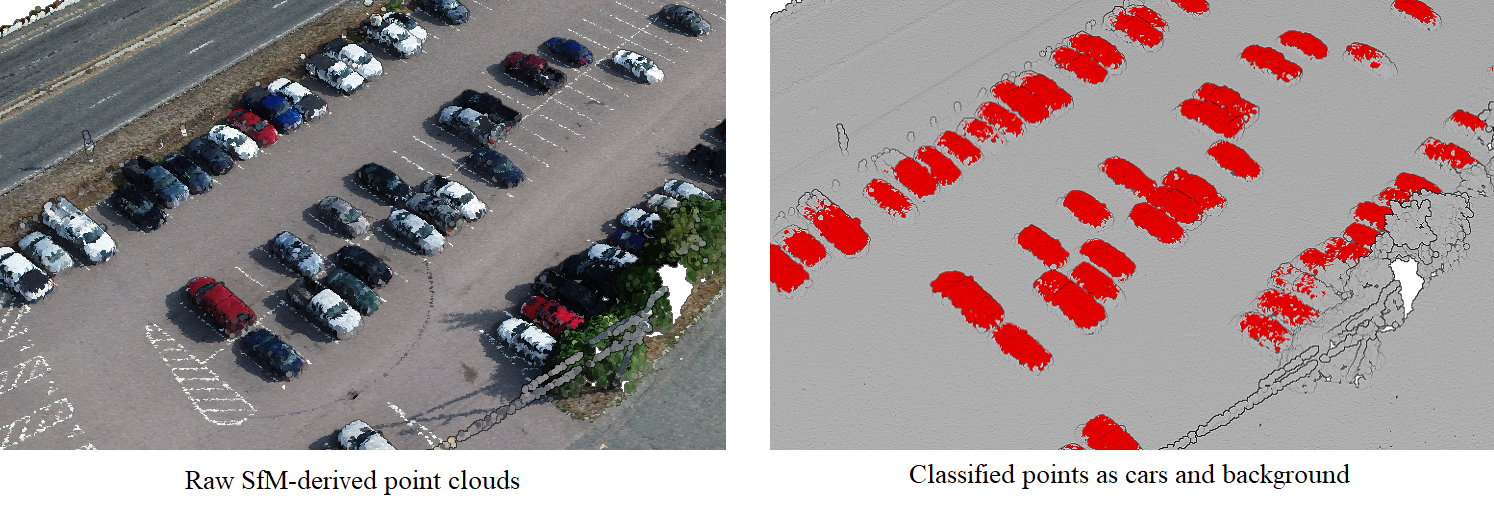</p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Area-of-interest-and-pre-processing" data-toc-modified-id="Area-of-interest-and-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Area of interest and pre-processing</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Visualization-of-prepared-data" data-toc-modified-id="Visualization-of-prepared-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization of prepared data</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Visualization-of-results-in-notebook" data-toc-modified-id="Visualization-of-results-in-notebook-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization of results in notebook</a></span></li><li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving the trained model</a></span></li><li><span><a href="#Classification-using-the-trained-model" data-toc-modified-id="Classification-using-the-trained-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification using the trained model</a></span></li><li><span><a href="#Visualization-of-results-in-ArcGIS-Pro" data-toc-modified-id="Visualization-of-results-in-ArcGIS-Pro-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Visualization of results in ArcGIS Pro</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

Historically, point clouds have been created by active remote sensing scanners, such as radar and laser scanners (LiDAR), that can be used on aerial, mobile, and terrestrial platforms. With the advancement in computer vision algorithms, point clouds can now also be created using Semi-Global Matching (SGM) and Structure from Motion (SfM) methods. These techniques are also based on overlapping imagery, just like 'manual stereo compilation', which is a photogrammetric method for creating point clouds. However, SfM and SGM methods both give far better and more detailed results and are less time consuming than the photogrammetric method <a href="#References">[1]</a>.

There are many technical terms that are loosely interchanged for such point clouds, such as SfM-derived point clouds, photogrammetric point clouds, synthetic point clouds, UAV point clouds, etc. In this sample notebook, we will be using the term: 'SfM-derived point clouds' with context to describe point clouds generated from ESRI's <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> and <a href="https://www.esri.com/en-us/arcgis/products/arcgis-drone2map/overview" target="_blank">ArcGIS Drone2Map</a>.  


SfM derived point clouds and LiDAR point clouds cannot be treated as the same. Some of the key differences between them are:

- Only the visible surface is modeled ('first returns') for SfM, SGM, or traditional photogrammetry methods <a href="#References">[1]</a>.


- Photo quality (exposure, shadows, etc.) and photo processing both have a significant impact on the quality of the generated point clouds in non-LiDAR approaches <a href="#References">[1]</a>.


- The SfM-derived point clouds can be enriched with the information for other imagery bands, like NIR. Even an NDVI band can be easily added as an additional attribute to the dataset <a href="#References">[1]</a>. 


- The geometry of the objects in SfM point clouds can have distorted/soft edges. This usually depends upon the quality of GCPs, variation in flying height of the drone, redundancies in overlapping imagery for a particular region, etc.


- In many cases, LiDAR-based data acquisition is costlier and requires more planning than drone imagery acquisition that generates point clouds using the SfM technique.



For these reasons, many of the traditional non-'deep learning' methods developed for LiDAR point clouds fall flat when it comes to SfM-derived point clouds. Fortunately, deep learning can fill this processing gap and help in the point cloud classification of these datasets.


Point clouds generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a> are first labeled with the 'objects of interest' to create the training data. Next, deep learning capabilities in 'ArcGIS API for Python' are utilized for the classification of these SfM-derived point clouds.

Further details on the PointCNN implementation in the API <i>(working principle, architecture, best practices, etc.)</i>, can be found in the <a href="https://developers.arcgis.com/python/guide/point-cloud-segmentation-using-pointcnn" target="_blank">PointCNN guide</a>, along with instructions on how to set up the Python environment. Additional sample notebooks related to PointCNN can be found in the <a href="https://developers.arcgis.com/python/sample-notebooks/" target="_blank">sample notebook section</a> on the website.

Before proceeding through this notebook, it is advised that you go through the <a href="https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#pointcnn" target="_blank">API reference</a> for PointCNN (`prepare_data()`, `Transform3d()`, and `PointCNN()`), along with the resources and tool references for point cloud classification using deep learning in ArcGIS Pro, found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

_**Objective:**_

<ol style="list-style-type:upper-roman">
<li>Classify points representing cars in SfM-derived point clouds using the API's PointCNN model. A model is trained for two classes, 'cars' and 'background'. Apart from the geometric information in the data, additional attributes (Red, Blue, and Green), are also used for model training.</li>
<br>


## Area of interest and pre-processing

Any SfM-derived point clouds and areas of interest can be used, but for this sample, we are using point clouds generated by <a href="https://www.esri.com/en-us/arcgis/products/site-scan-for-arcgis/overview" target="_blank">Site Scan for ArcGIS</a>, using drone imagery of some parking lots in the United States. The dataset already has points labeled for 'cars', represented by classcode '18', and 'background', represented by classcode '0'.

_**Pre-processing steps:**_

- Split the `.las` files into three unique sets, one for training, one for validation, and one for testing. Create LAS datasets for all three sets using the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-las-dataset.htm" target="_blank">'Create LAS Dataset'</a>  tool. There is no fixed rule, but generally, the validation data for point clouds in `.las` format should be at least 5-10 % <i>(by size)</i> of the total data available, with appropriate diversity within the validation dataset. <i>(For ease in splitting the big `.las` files into the appropriate ratios, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/tile-las.htm" target="_blank">'Tile LAS'</a> tool can be used.)</i>


- Alternatively, polygons can also be used to define regions of interest that should be considered as training or validation datasets. These polygons can be used later in the export tool. If the dataset is very large, then the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/build-las-dataset-pyramid.htm" target="_blank">'Build LAS Dataset Pyramid'</a> tool can be leveraged for faster rendering/visualization of the data, which will also help in exploring and splitting the dataset.


- If there is a pre-trained imagery model for the object of interest, then that model can help in creating the training dataset. The pre-trained imagery model can be used on the data from which the SfM-derived point cloud was created. Later, the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/set-las-class-codes-using-raster.htm" target="_blank">'Set LAS Class Codes Using Raster'</a> tool or the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/set-las-class-codes-using-features.htm" target="_blank">'Set LAS Class Codes Using Features'</a>  tool can be used to classify point cloud datasets using vector or raster labels obtained from the imagery pre-trained model. For example, in this sample notebook, the objects of interest are 'car'(s), and overlapping drone imagery is used to generate the point clouds. As such, ESRI's <a href="https://arcg.is/1OabnW" target="_blank">Car Detection - USA model</a> can be used on the orthophoto to generate car footprint polygons that can later be used to classify cars in the point cloud. Also, as the point cloud is derived from the imagery, moving objects, like a 'car', will not change positions, which can happen when using LiDAR data.

## Data preparation

_**Imports:**_

In [ ]:
from arcgis.learn import prepare_data, Transform3d, PointCNN
from arcgis.gis import GIS
gis = GIS()

**Note:** The data used in this sample notebook can be downloaded as a zip file, from <a href="https://arcg.is/4rO8n"  target="_blank">here</a>. It contains both 'training data' and 'test data', where the 'test data' is used for inferencing. It can also be accessed via its `itemId`, as shown below.

In [ ]:
training_data = gis.content.get('cae020a8e7f24fedb1359d114ca3abf1')
training_data

<Item title:"Classification_of_sfm_derived_point_clouds_using_deep_learning" type:Image Collection owner:api_data_owner>

_**Exporting the data:**_

In this step, `.las` files are converted to a 'HDF5 binary data format'. For this step of exporting the data into an intermediate format, use the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards <i>(as shown in figure 1)</i>.

The tool needs two LAS datasets, one for the training data and one for the validation data or regions of interest defined by polygons. Next, the `block size` is set to '50 meters', as our objects of interest will mostly be smaller than that, and the default value of '8192' is used for `block point limit`.


<p align="center">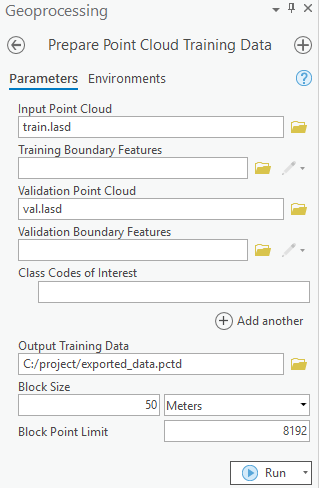</p>

<center>Figure 1. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool.</center>


Here, all the additional attributes are included in the exported data. Later, a subset of additional attributes like intensity, number of returns, etc. can be selected that will be considered for training.

After the export is completed at the provided output path, the folder structure of the exported data will have two folders, each with converted HDF files in them <i>(as shown in figure 2)</i>. The exported training and validation folders will also contain histograms of the distributions of data that provide additional understanding and can help in tweaking the parameters that are being used in the workflow.

<p align="center">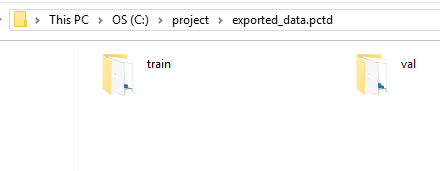</p>

<center>Figure 2. Exported data.</center>

_**Preparing the data:**_

For `prepare_data()`, deciding the value of `batch_size` will depend on either the available RAM or VRAM, depending upon whether CPU or GPU is being used. `transforms` can also be used for introducing rotation, jitter, etc. to make the dataset more robust. `data.classes` can be used to verify what classes the model will be learning about.

The `classes_of_interest` and `min_points` parameters can be used to filter out less relevant blocks. These parameters are useful when training a model for SfM-derived or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, usage of these features can result in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

In this sample notebook X, Y, Z, Red, Blue, and Green are considered for training the model, so all three attributes, 'Red', 'Blue', and 'Green', are selected as `extra_features`. The names of the classes are also defined using `class_mapping` and will be saved inside the model for future reference.

In [ ]:
output_path = r'C:\project\exported_data.pctd'

In [ ]:
colormap = {'0':[255,69,0], '18':[253,247,83]}

In [ ]:
data = prepare_data(output_path, 
                    dataset_type='PointCloud',
                    batch_size=2,
                    min_points=800,
                    transforms=None,
                    color_mapping=colormap,
                    extra_features=['red', 'blue', 'green'],
                    class_mapping={'18':'car','0':"background"})

In [ ]:
data.classes

## Visualization of prepared data

`show_batch()` helps in visualizing the exported data. Navigation tools available in the graph can be used to zoom and pan to the area of interest.

In [ ]:
data.show_batch(rows=1)

<p align="center"><img src="../../static/img/pointcnn_sample2_show_b.gif" /></p>

<center>Figure 3. Visualization of batch.</center>

## Training the model

First, the PointCNN model object is created, utilizing the prepared data.

In [ ]:
pc = PointCNN(data)

Next, the `lr_find()` function is used to find the optimal learning rate that controls the rate at which existing information will be overwritten by newly acquired information throughout the training process. If no value is specified, the optimal learning rate will be extracted from the learning curve during the training process.

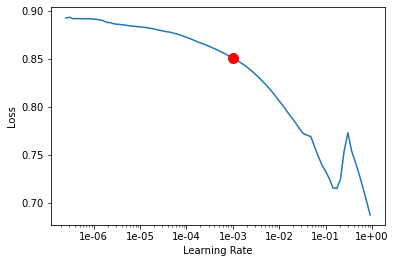

0.001

In [ ]:
pc.lr_find()

The `fit()` method is used to train the model, either applying a new 'optimum learning rate' or the previously computed 'optimum learning rate' <i>(any other user-defined learning rate can also be used.)</i>.

If `early_stopping` is set to 'True', then the model training will stop when the model is no longer improving, regardless of the `epochs` parameter value specified. The best model is selected based on the metric selected in the `monitor` parameter. A list of `monitor`'s available metrics can be generated using the `available_metrics` property.

An 'epoch' means the dataset will be passed forward and backward through the neural network one time, and if `Iters_per_epoch` is used, a subset of data is passed per epoch. To track information like gradients, losses, metrics, etc. while the model training is in progress, `tensorboard` can be set to 'True'.


In [ ]:
pc.available_metrics

['valid_loss', 'accuracy', 'precision', 'recall', 'f1']

In [ ]:
pc.fit(20, 0.001, monitor='f1', tensorboard=True, early_stopping=True)

Monitor training on Tensorboard using the following command: 'tensorboard --host=DEMOPC01 --logdir="C:\project\exported_data.pctd\training_log",'


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.036672,0.039147,0.983295,0.869097,0.788823,0.811299,54:08
1,0.035641,0.036635,0.985743,0.877212,0.811648,0.832864,53:52
2,0.035747,0.036269,0.985590,0.863960,0.799648,0.820435,54:08
3,0.035532,0.036443,0.985335,0.852369,0.794295,0.813295,53:56
4,0.035454,0.037829,0.984680,0.859983,0.794513,0.813838,54:05
5,0.034591,0.040312,0.982558,0.866561,0.789968,0.811450,53:44
6,0.033419,0.040615,0.982502,0.862325,0.788621,0.810044,54:26


Epoch 7: early stopping


## Visualization of results in notebook

`show_results()` will visualize the results of the model for the same scene as the ground truth. Navigation tools available in the graph can be used to zoom and pan to the area of interest.

The `compute_precision_recall()` method can be used to compute per-class performance metrics, which are calculated against the validation dataset.

In [ ]:
pc.show_results(rows=1)

<p align="center"><img src="../../static/img/pointcnn_sample2_show_r.gif" /></p>

<center>Figure 4. Visualization of results.</center>

## Saving the trained model

The last step related to training is to save the model using the `save()` method. Along with the model files, this method also saves performance metrics, a graph of training loss vs validation loss, sample results, etc. <i>(as shown in figure 5)</i>.

<p align="center">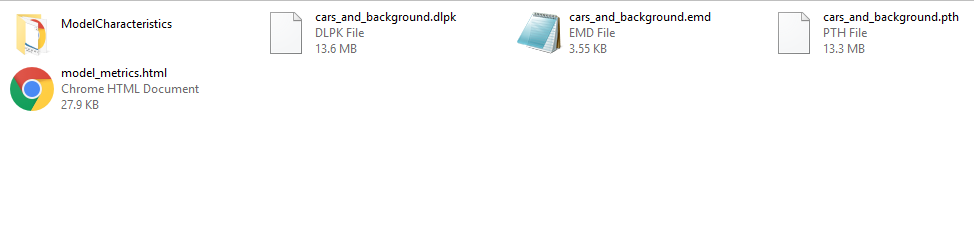</p>

<center>Figure 5. Saved model.</center>


In [ ]:
pc.save('cars_and_background')

WindowsPath('models/cars_and_background')

## Classification using the trained model

For inferencing, <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards, can be used <i>(as shown in figure 6)</i>.


<p align="center">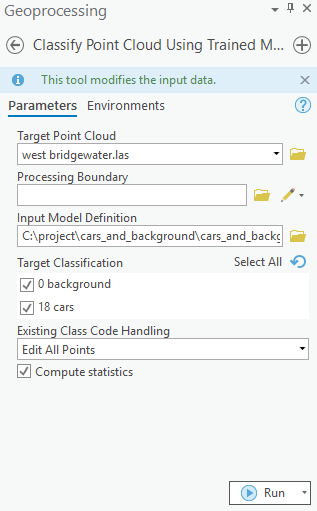</p>

<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool.</center>


Additional features, like target classification and class preservation in input data, are also available. After the prediction, LAS files will have 'car points', with the class code '18', and the rest of the points will have the class code '0' <i>(referred to as 'Background' in this sample)</i>. To visualize the results after the process is completed, the 'Symbology' can be changed to 'class' from the 'Appearance' tab, if not done initially.

## Visualization of results in ArcGIS Pro

<p align="center">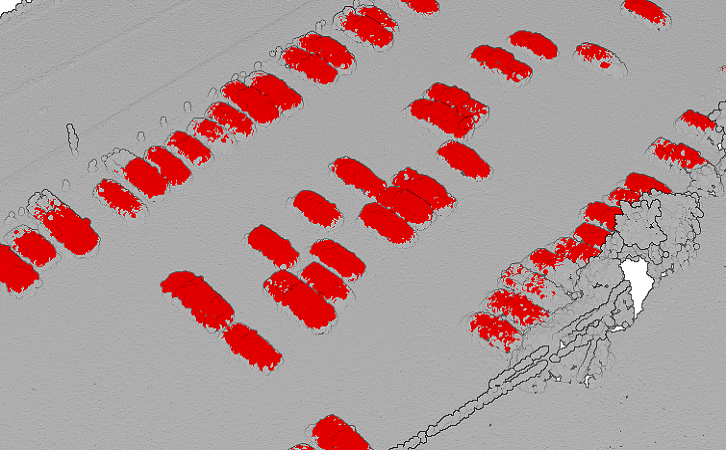</p>

<center>Figure 7. Visualization of results in ArcGIS Pro.</center>

<i> This <a href="https://geosaurus.maps.arcgis.com/home/webscene/viewer.html?webscene=6a50627e143c47fe9f040a4b5eb5a86e" target="_blank">web scene</a> has the final outputs related to the illustrated test data in this notebook. It can also be accessed via its `itemId`, as shown below.</i>

In [ ]:
results = gis.content.get('6a50627e143c47fe9f040a4b5eb5a86e')
results

<Item title:"Classification of SfM-derived point clouds using deep learning" type:Web Scene owner:api_data_owner>

## Conclusion

This notebook has demonstrated the workflow for training a deep learning model for the classification of points representing 'cars' in SfM-derived point clouds, using additional attributes, like Red, Blue, and Green bands. A similar approach can be applied to classify other objects of interest, like trees, buildings, ground, etc.

## References

- Dharmapuri, S., & Tully, M. (2018). Evolution of Point Cloud. LIDAR Magazine. https://lidarmag.com/2018/07/16/evolution-of-point-cloud/



